# Reserves QC with lognormal distribution (paper or code?)

Those who have performed reserves estimation will have encountered the need to calculate P10, P50, and P90 of oil volumes for reserves reporting. Often this work is the result of an uncertainty analysis from which these percentiles can be obtained (with P90 being the value that represents a 90% probability of reaching or exceeding said volumes i.e., **the lowest volume**)

However, we don't always have such analysis available, and the approach tends to be more deterministic, using different methods, some not so conventional. Regardless of the method, we might obtain a high and low estimate, but we're not sure what the P50 should be. Or alternatively, we might have a low and medium estimate and want to know a high value or P10.

A simple method to verify these values is using the lognormal distribution. For this, a lognormal distribution paper can be used. If we know that the reserves follow a lognormal distribution, **could we find the value of an unknown percentile, having information from two other percentiles?** Yes!! In this notebook, we'll show you a simple code to perform these calculations (without paper 😁) and you can use it for your own QC!

## Libraries

The following code is very simple, but we still need powerful libraries like scipy to generate the distributions we need:

In [1]:
import scipy.stats as st
from collections import namedtuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Problem definition

Next, let's define our problem. We need to know the reserves value at a certain percentile, knowing two other percentiles. Below, enter the data for the values you already know and the one you need to estimate (using PRMS nomenclature):

In [4]:
percentile_1 = '50'
reserves_1 = '500000'

# --

percentile_2 = '10'
reserves_2 = '1500000'

# --

unknown_percentile = '90'

Let's remember that the definition of percentile is the cumulative probability (CDF) that a random variable $X$ is less than $x$, where the CDF is defined by the equation:

$$
F_{X}(x)=\mathrm{P}(X \leq x)
$$

The definition used by PRMS is different; specifically, it uses $1 - F_X(x)$ to define the percentiles related to reserves, or alternatively $P(X>x)$.

In the following code block, we process the variables defined previously.

In [5]:
Percentile = namedtuple('Percentile', 'p value')

p1 = Percentile(1 - (float(percentile_1) / 100), float(reserves_1))
p2 = Percentile(1 - (float(percentile_2) / 100), float(reserves_2))
p_find = 1 - (float(unknown_percentile) / 100)

## Resolution

With these premises, let's establish equations to solve this problem.

The objective is to find the parameters of the lognormal distribution from the known percentile values. Since we're dealing with a lognormal distribution, we can start with the definition of the standard normal distribution, which incorporates the parameters we need to find (mean $\mu$ and standard deviation $\sigma$):

$$
\begin{aligned}
&z_{1}=\frac{ln(x_{1})-\mu}{\sigma} \\
&z_{2}=\frac{ln(x_{2})-\mu}{\sigma}
\end{aligned}
$$

In this case, $x_1$ and $x_2$ correspond to the reserves values of the percentiles, and we take the natural logarithm to convert it to a normal distribution. And what about the values of $z_1$ and $z_2$? Well, they correspond to the standard normal distribution values of the defined percentiles for each of the values (remember those famous tables used in university statistics class?).

Since we're using Python, we don't need these tables! We'll use the ppf method (percent point function) to calculate the $z$ value of the standard normal distribution for the percentiles we need:

In [6]:
z1 = st.norm.ppf(p1.p)
z2 = st.norm.ppf(p2.p)
print(f"z1: {z1}, z2: {z2}")

z1: 0.0, z2: 1.2815515655446004


Great! Now let's establish a system of equations that allows us to find $\mu$ and $\sigma$ using the values of $z$ and $x$. Rearranging the previous equations, we have:

$$
\begin{aligned}
&\mu+z_{1} \sigma=\ln \left(x_{1}\right) \\
&\mu+z_{2} \sigma=\ln \left(x_{2}\right)
\end{aligned}
$$

If we make an analogy of this equation to something more familiar or that we've probably seen before, we have a system of equations of the form:

$$
\begin{aligned}
&a_{11} x_{1}+a_{12} x_{2}=b_{1} \\
&a_{21} x_{1}+a_{22} x_{2}=b_{2}
\end{aligned}
$$

If we use the matrix representation of the system of equations, we have:

$$
\begin{gathered}
{\left[\begin{array}{ll}
a_{11} & a_{12} \\
a_{21} & a_{22}
\end{array}\right]\left[\begin{array}{l}
x_{1} \\
x_{2}
\end{array}\right]=\left[\begin{array}{l}
b_{1} \\
b_{2}
\end{array}\right]}
\end{gathered}
$$

Which leads to the traditional system of equations in the form:

$$
Ax = b
$$

With this intuition, we have the necessary tools and information to program the system of equations using numpy:

In [7]:
A = np.array([[1, z1], [1, z2]])  # Definition of matrix A (2x2)
b = np.array(np.log([p1.value, p2.value]))  # Definition of vector b (2x1)
# Solve the system of equations
result = np.linalg.solve(A, b)
# Extract mu and sigma results from the solution
mu = result[0]
sigma = result[1]

print(f'mu: {mu}')
print(f'sigma: {sigma}')

mu: 13.122363377404328
sigma: 0.8572517237737923


Did someone say they never wanted to see linear algebra again in their life 😅? Fortunately, this is a simple example that brings back memories of this beautiful subject.

Now that we have $\mu$ and $\sigma$, we need to find the unknown percentile. For this, we'll directly use scipy's lognormal function, so we need to transform the previously calculated mean using the exponential function.

Then, we'll use the ppf method again to find the value of the unknown percentile

In [8]:
M = np.exp(mu)
s = sigma
value = st.lognorm.ppf(p_find, s, scale=M)
print(f"P{unknown_percentile}: {round(value, 2)}")

P90: 166666.67


This way we find the unknown percentile of a lognormal distribution using two known percentile values. We'll finish with a graph that helps us visualize the calculated distribution using this method and the percentiles. The unknown percentile calculation is shown in red.

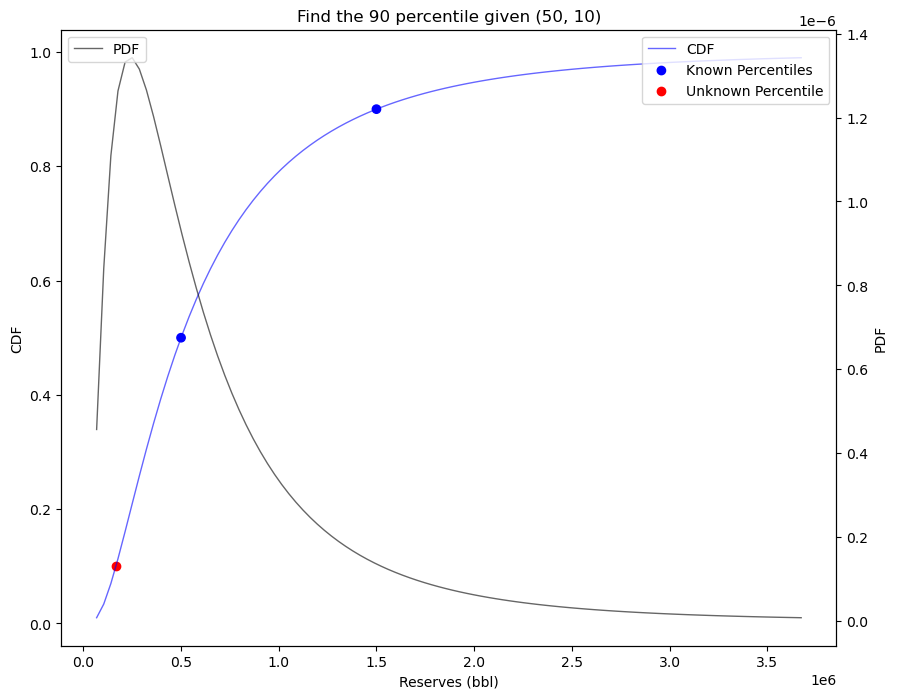

In [9]:
fig_0, ax_0 = plt.subplots(1, 1, figsize=(10, 8))

min = st.lognorm.ppf(0.01, s, scale=M)
max = st.lognorm.ppf(0.99, s, scale=M)
n_points = 100
x = np.linspace(min, max, n_points)

ax_0.plot(x, st.lognorm.cdf(x, s, scale=M), 'b-', lw=1, alpha=0.6, label='CDF')
x_scatter = [p1.value, p2.value, value]
y_scatter = [p1.p, p2.p, p_find]
colors = ['b', 'b', 'r']
ax_0.scatter(x_scatter[:2], y_scatter[:2], c=colors[:2], label="Known Percentiles")
ax_0.scatter(x_scatter[-1], y_scatter[-1], c=colors[-1], label="Unknown Percentile")
ax_0.set_xlabel("Reserves (bbl)")
ax_0.set_ylabel('CDF')
ax_0.set_title(f"Find the {int(100 - p_find * 100)} "
f"percentile given {int(100 - p1.p * 100), int(100 - p2.p * 100)}")
# Plot the pdf
ax_1 = ax_0.twinx()
ax_1.plot(x, st.lognorm.pdf(x, s, scale=M), 'k-', lw=1, alpha=0.6, label='PDF')
ax_1.set_ylabel('PDF')
ax_0.legend(loc="upper right")
ax_1.legend(loc="upper left")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f227edf6-dc29-4d11-9a58-5fff1df070b9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>